df_alpha_beta = df_alpha_beta[(df_alpha_beta['complex.id'] != 0)
                              & (df_alpha_beta['gene'] == 'TRB')
                              # & (df_alpha_beta['antigen.species'] == 'SARS-CoV-2')
                              & (df_alpha_beta['species'] == 'MusMusculus')
                              # & (df_alpha_beta['vdjdb.score'] >= 2)
                              ].copy()

In [62]:
# 首先导入相关库
import pandas as pd
import numpy as np
###one-hot 对单链
# 加载数据
df = pd.read_csv("/Users/lifangyi/Desktop/UOB/mini/data_clean.csv", sep='\t')
df = df[(df['complex.id'] !=0) & (df['gene'] == 'TRB') & 
        (df['antigen.species'] == 'SARS-CoV-2') &   
        (df['species'] == 'HomoSapiens')]
cdr3_sequences = df['cdr3'].tolist()

# 创建氨基酸和表位的one-hot编码字典
amino_acids = set(''.join(cdr3_sequences))
amino_acid_to_index = {aa: i for i, aa in enumerate(sorted(amino_acids))}

# 准备编码函数
def encode_sequence(seq, max_length, encoding_dict):
    encoded = np.zeros((max_length, len(encoding_dict)), dtype=int)
    for i, amino_acid in enumerate(seq):
        if amino_acid in encoding_dict:
            encoded[i, encoding_dict[amino_acid]] = 1
    return encoded.flatten()

# 计算最大长度
max_length_cdr3 = max(len(seq) for seq in cdr3_sequences)

# 对cdr3序列进行one-hot编码
cdr3_encoded = np.array([encode_sequence(seq, max_length_cdr3, amino_acid_to_index) for seq in cdr3_sequences])


# 将编码后的数据转换为字符串形式存储
cdr3_encoded_strings = [' '.join(map(str, seq)) for seq in cdr3_encoded]

# 将结果写入新的DataFrame
encoded_df = pd.DataFrame({
    'cdr3encode': cdr3_encoded_strings,
    'epitope': df['antigen.epitope']
})

# 保存到CSV文件
encoded_df.to_csv('CDR3_encoded_dimension.csv', index=False)


In [91]:
# 首先导入相关库
import pandas as pd
import numpy as np
###one-hot 
# 加载数据
df = pd.read_csv("/Users/lifangyi/Desktop/data_clean_small_MusMusculus.csv", sep='\t')
# df = df[
#         #(df['complex.id'] !=0) & (df['gene'] == 'TRB') & 
#         #(df['antigen.species'] == 'SARS-CoV-2') &   
#         (df['species'] == 'HomoSapiens')]
amino_acids = set(''.join(df['cdr3_a_aa'].dropna()) + ''.join(df['cdr3_b_aa'].dropna()))
amino_acid_to_index = {aa: i for i, aa in enumerate(sorted(amino_acids))}



def encode_sequence(seq, max_length, encoding_dict):
    encoded = np.zeros((max_length, len(encoding_dict)), dtype=int)
    for i, amino_acid in enumerate(seq):
        if amino_acid in encoding_dict:
            encoded[i, encoding_dict[amino_acid]] = 1
    return encoded.flatten()


# 计算最大长度
max_length_cdr3_a = max(len(seq) for seq in df['cdr3_a_aa'].dropna())
max_length_cdr3_b = max(len(seq) for seq in df['cdr3_b_aa'].dropna())

# 对 CDR3a 和 CDR3b 序列进行 one-hot 编码
df['CDR3a_encoded'] = [encode_sequence(seq, max_length_cdr3_a, amino_acid_to_index) for seq in df['cdr3_a_aa'].dropna()]
df['CDR3b_encoded'] = [encode_sequence(seq, max_length_cdr3_b, amino_acid_to_index) for seq in df['cdr3_b_aa'].dropna()]

# 将编码转换为字符串形式以便保存
df['CDR3a_encoded'] = [' '.join(map(str, seq)) for seq in df['CDR3a_encoded']]
df['CDR3b_encoded'] = [' '.join(map(str, seq)) for seq in df['CDR3b_encoded']]

encoded_df = df[['CDR3a_encoded', 'CDR3b_encoded', 'antigen.epitope']]

# 保存到CSV文件
encoded_df.to_csv('CDR3_encoded_dimension_doublechain_mouse.csv', index=False)


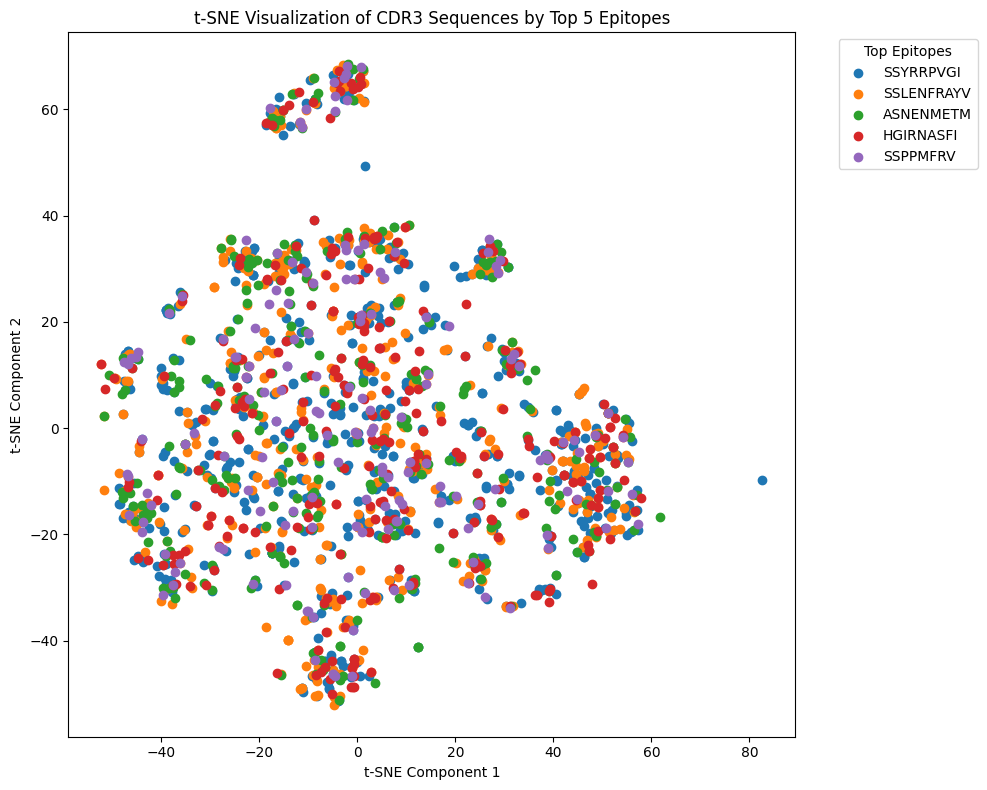

In [76]:
cdr3_a_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3a_encoded']])
cdr3_b_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3b_encoded']])

X = np.hstack((cdr3_a_encoded, cdr3_b_encoded,
               #v_b_gene_encoded.reshape(-1, 1), j_b_gene_encoded.reshape(-1, 1),
               #v_a_gene_encoded.reshape(-1, 1), j_a_gene_encoded.reshape(-1, 1))
              ))
tsne = TSNE(n_components = 2, random_state = 42)
X_embedded = tsne.fit_transform(X)

epitope_counts = pd.Series(epitopes).value_counts()
top_epitopes = epitope_counts.nlargest(5).index.tolist()

plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(top_five_epitopes)))
# epitope_color_dict = dict(zip(top_five_epitopes, colors))

for i, epitope in enumerate(top_epitopes):
    indices = np.where(epitopes == epitope)
    #if epitope == 'SSPPMFRV' or epitope == 'HGIRNASFI':
    plt.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=epitope)

plt.title('t-SNE Visualization of CDR3 Sequences by Top 5 Epitopes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Top Epitopes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 从之前存储的编码数据中读取
cdr3_encoded_strings = encoded_df['cdr3encode']
cdr3_encoded = np.array([np.fromstring(seq, sep=' ', dtype=int) for seq in cdr3_encoded_strings])

# 应用 t-SNE 降维到2维
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(cdr3_encoded)

# 可视化结果
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of CDR3 Sequences')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


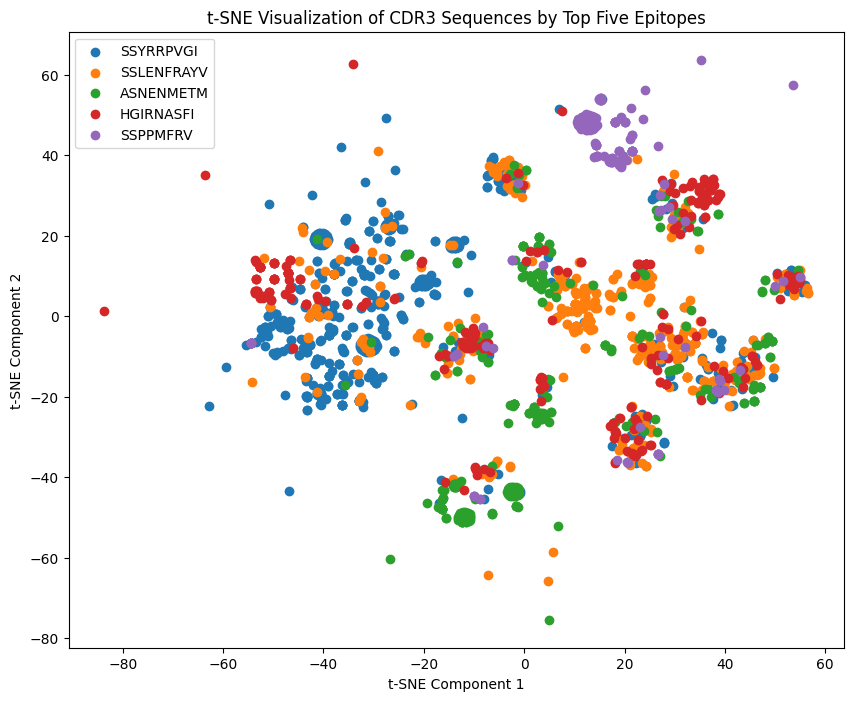

In [54]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
###kmer single chain
# 加载数据
df = pd.read_csv("/Users/lifangyi/Desktop/UOB/mini/data_clean_MusMusculus.csv", sep='\t')
df = df[(df['complex.id'] != 0) & (df['gene'] == 'TRB') & 
        (df['species'] == 'MusMusculus')]
cdr3_sequences = df['cdr3'].tolist()
epitopes = df['antigen.epitope'].tolist()

def get_kmers(seq, k=3):
    return [seq[x:x+k] for x in range(len(seq) - k + 1)]

k = 3  
cdr3_kmers = [' '.join(get_kmers(seq, k)) for seq in cdr3_sequences]

vectorizer = CountVectorizer()
X_encoded = vectorizer.fit_transform(cdr3_kmers)


tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_encoded.toarray())  

epitope_counts = pd.Series(epitopes).value_counts()
top_five_epitopes = epitope_counts.nlargest(5).index.tolist()

plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(top_five_epitopes)))
# epitope_color_dict = dict(zip(top_five_epitopes, colors))

for epitope in top_five_epitopes:
    subset = X_embedded[np.array(epitopes) == epitope]
    plt.scatter(subset[:, 0], subset[:, 1], label=epitope)

plt.title('t-SNE Visualization of CDR3 Sequences by Top Five Epitopes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


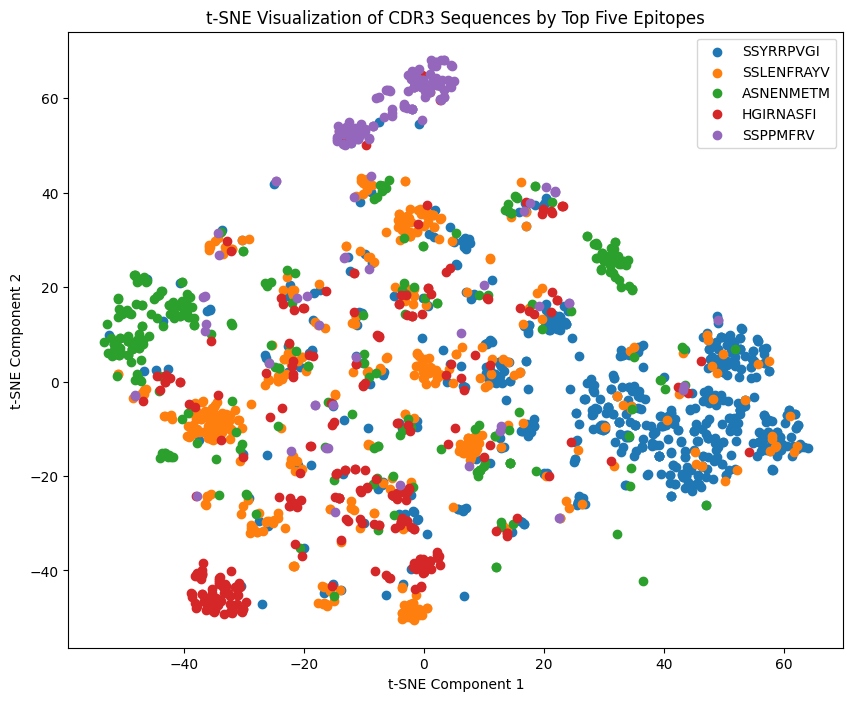

In [83]:
### kmer double chain
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 加载数据
df = pd.read_csv("/Users/lifangyi/Desktop/UOB/mini/data_clean_MusMusculus.csv", sep='\t')

# 定义 k-mer 函数
def get_kmers(sequence, k=3):
    return [sequence[x:x+k] for x in range(len(sequence) - k + 1)]

# 应用 k-mer 编码到 CDR3 序列
k = 3
df['CDR3a_kmers'] = df['cdr3_a_aa'].dropna().apply(lambda x: ' '.join(get_kmers(x, k)))
df['CDR3b_kmers'] = df['cdr3_b_aa'].dropna().apply(lambda x: ' '.join(get_kmers(x, k)))

# 使用 CountVectorizer 转换 k-mer 为频率特征
vectorizer = CountVectorizer()
X_a = vectorizer.fit_transform(df['CDR3a_kmers'].dropna())
X_b = vectorizer.fit_transform(df['CDR3b_kmers'].dropna())

# 合并 CDR3a 和 CDR3b 的特征
from scipy.sparse import hstack
X = hstack([X_a, X_b])

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

# 统计和筛选前五个最常见的 epitope
top_five_epitopes = df['antigen.epitope'].value_counts().nlargest(5).index

# 过滤数据以仅包括前五个epitope
filtered_indices = df['antigen.epitope'].isin(top_five_epitopes)
X_embedded_filtered = X_embedded[filtered_indices]
epitopes_filtered = df['antigen.epitope'][filtered_indices]

# 可视化
plt.figure(figsize=(10, 8))
for epitope in top_five_epitopes:
    indices = np.where(epitopes_filtered == epitope)
    plt.scatter(X_embedded_filtered[indices, 0], X_embedded_filtered[indices, 1], label=epitope)

plt.title('t-SNE Visualization of CDR3 Sequences by Top Five Epitopes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


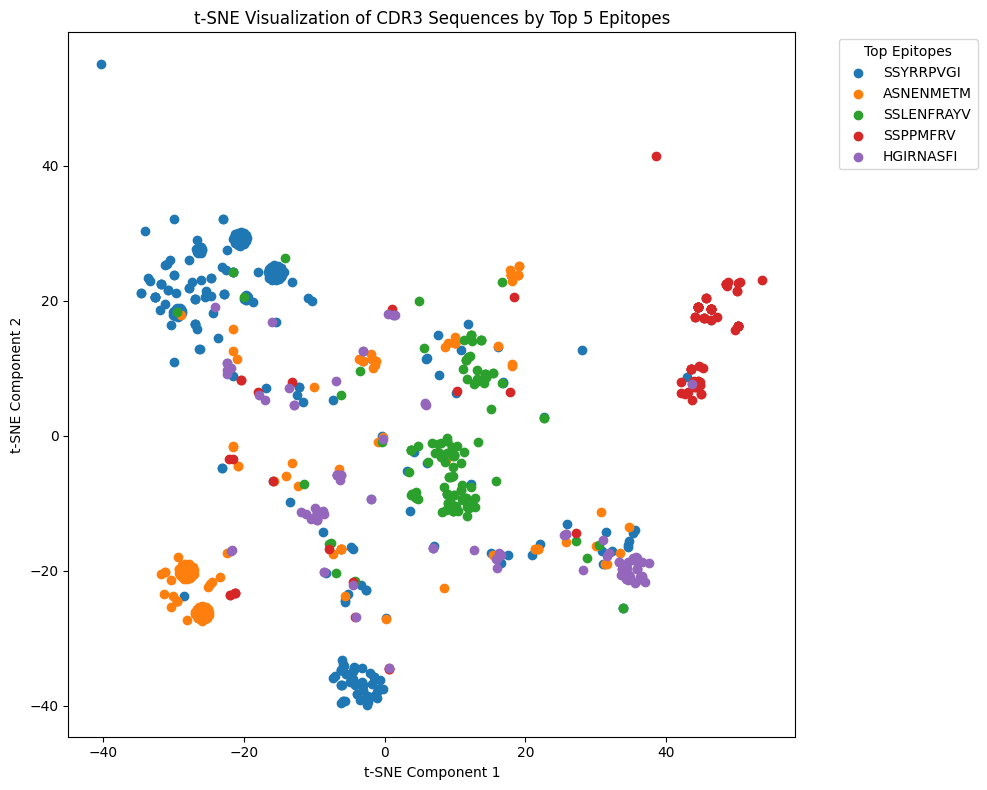

In [101]:
###single chain

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

###tsne
encoded_df = pd.read_csv('CDR3_encoded_dimension_doublechain_mouse.csv')
cdr3_encoded_strings = encoded_df['CDR3b_encoded']
epitopes = encoded_df['antigen.epitope']

cdr3_encoded = np.array([np.fromstring(seq, sep=' ', dtype=int) for seq in cdr3_encoded_strings])

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(cdr3_encoded)

epitope_counts = epitopes.value_counts()
top_epitopes = epitope_counts.nlargest(5).index #####


plt.figure(figsize=(10, 8))
#colors = plt.cm.get_cmap('tab20', len(top_epitopes)) 

for i, epitope in enumerate(top_epitopes):
    indices = np.where(epitopes == epitope)
    #if epitope != 'NLVPMVATV':
    plt.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=epitope)

plt.title('t-SNE Visualization of CDR3 Sequences by Top 5 Epitopes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Top Epitopes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


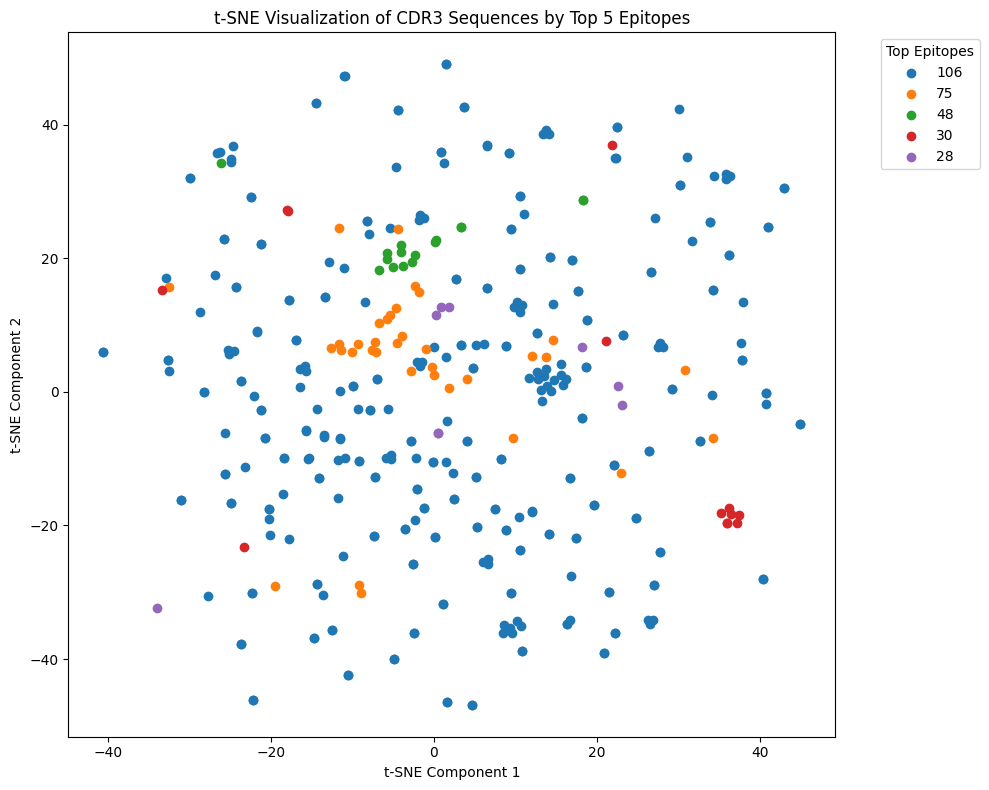

In [35]:

###double chain
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

###tsne
encoded_df = pd.read_csv('CDR3_encoded_complete_final_score.csv')
cdr3_encoded_strings_alpha = encoded_df['CDR3a_encoded']
cdr3_encoded_strings_beta = encoded_df['CDR3b_encoded']
epitopes = encoded_df['epitope_encoded']

cdr3_encoded_alpha = np.array([np.fromstring(seq, sep=' ', dtype=int) for seq in cdr3_encoded_strings_alpha])
cdr3_encoded_beta = np.array([np.fromstring(seq,sep=' ',dtype = int) for seq in cdr3_encoded_strings_beta])

X = np.hstack((cdr3_encoded_alpha, cdr3_encoded_beta ,
               #v_b_gene_encoded.reshape(-1, 1), j_b_gene_encoded.reshape(-1, 1),
               #v_a_gene_encoded.reshape(-1, 1), j_a_gene_encoded.reshape(-1, 1))
              ))
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

epitope_counts = epitopes.value_counts()
top_epitopes = epitope_counts.nlargest(5).index #####


plt.figure(figsize=(10, 8))
#colors = plt.cm.get_cmap('tab20', len(top_epitopes)) 

for i, epitope in enumerate(top_epitopes):
    indices = np.where(epitopes == epitope)
    #if epitope != 'NLVPMVATV':
    #if epitope != 106:
    plt.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=epitope)

plt.title('t-SNE Visualization of CDR3 Sequences by Top 5 Epitopes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Top Epitopes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


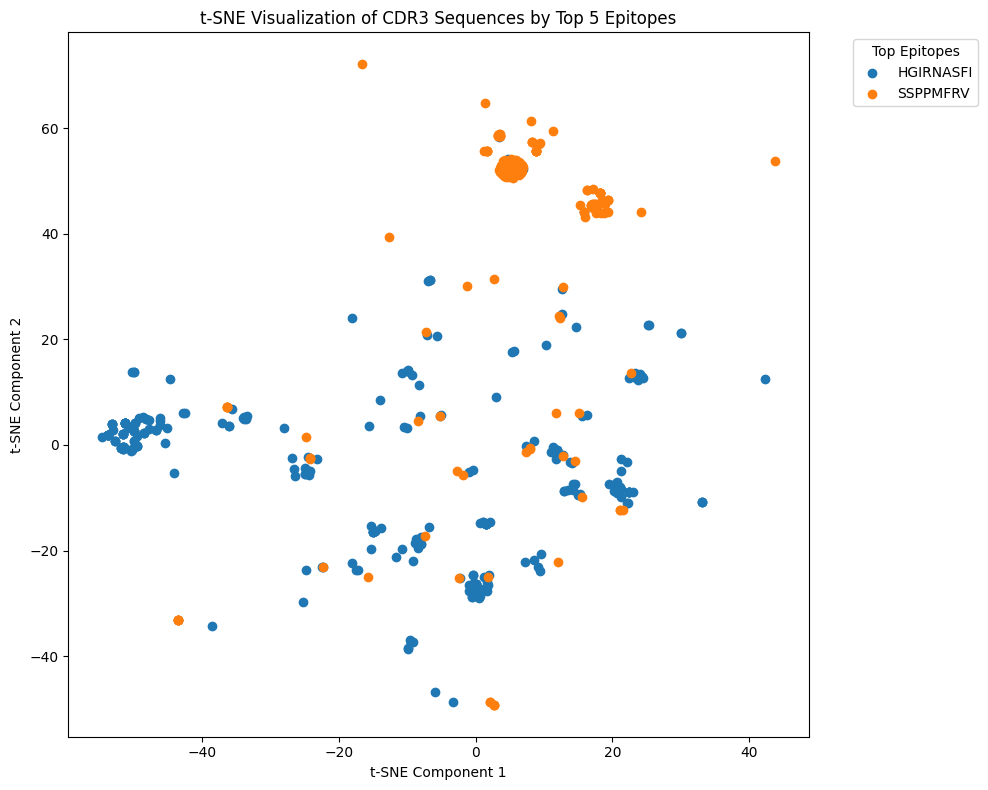

In [60]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

###tsne
encoded_df = pd.read_csv('CDR3_encoded_dimension.csv')
cdr3_encoded_strings = encoded_df['cdr3encode']
epitopes = encoded_df['epitope']

cdr3_encoded = np.array([np.fromstring(seq, sep=' ', dtype=int) for seq in cdr3_encoded_strings])

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(cdr3_encoded)

epitope_counts = epitopes.value_counts()
top_epitopes = epitope_counts.nlargest(5).index #####


plt.figure(figsize=(10, 8))
#colors = plt.cm.get_cmap('tab20', len(top_epitopes)) 

for i, epitope in enumerate(top_epitopes):
    indices = np.where(epitopes == epitope)
    if epitope == 'SSPPMFRV' or epitope == 'HGIRNASFI':
        plt.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=epitope)

plt.title('t-SNE Visualization of CDR3 Sequences by Top 5 Epitopes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Top Epitopes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [34]:
print(epitope_counts)

epitope
NLVPMVATV       2158
NEGVKAAW         312
IPSINVHHY         11
CPSQEPMSIYVY       6
TPRVTGGGAM         4
Name: count, dtype: int64


In [86]:
df = pd.read_csv('/Users/lifangyi/Desktop/UOB/mini/data_clean.csv', sep = '\t')
df = df[(df['complex.id'] == 0) & (df['gene'] == 'TRB')]
print(len(df))

24128


In [78]:
print(len(df))

24623


In [87]:
df = pd.read_csv('/Users/lifangyi/Desktop/UOB/mini/data_clean.csv', sep = '\t')
df = df[(df['complex.id'] == 0) & (df['gene'] == 'TRA')]
print(len(df))

7455


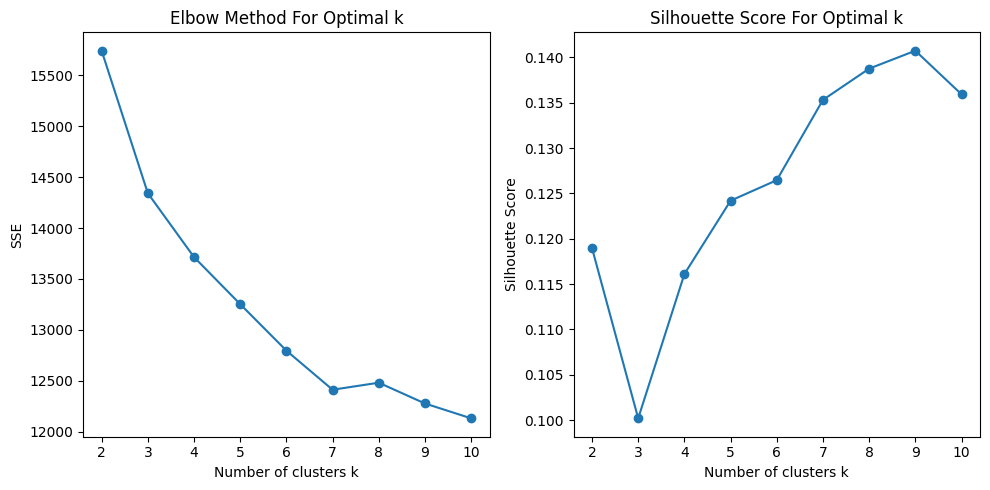

In [14]:
###find k
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 读取数据
encoded_df = pd.read_csv('CDR3_encoded_dimension_doublechain_mouse.csv')
cdr3_a_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3a_encoded']])
cdr3_b_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3b_encoded']])
cdr3_encoded_combined = np.hstack((cdr3_a_encoded, cdr3_b_encoded))

# 定义要测试的k值范围
k_range = range(2, 11)

# 初始化列表来存储每个k的SSE和轮廓系数
sse = []
silhouette_scores = []

# 循环不同的k值
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(cdr3_encoded_combined)
    sse.append(kmeans.inertia_)  # 存储每个k的SSE
    silhouette_scores.append(silhouette_score(cdr3_encoded_combined, clusters))  # 存储轮廓系数

# 绘制SSE的肘部图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')

# 绘制轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.tight_layout()
plt.show()


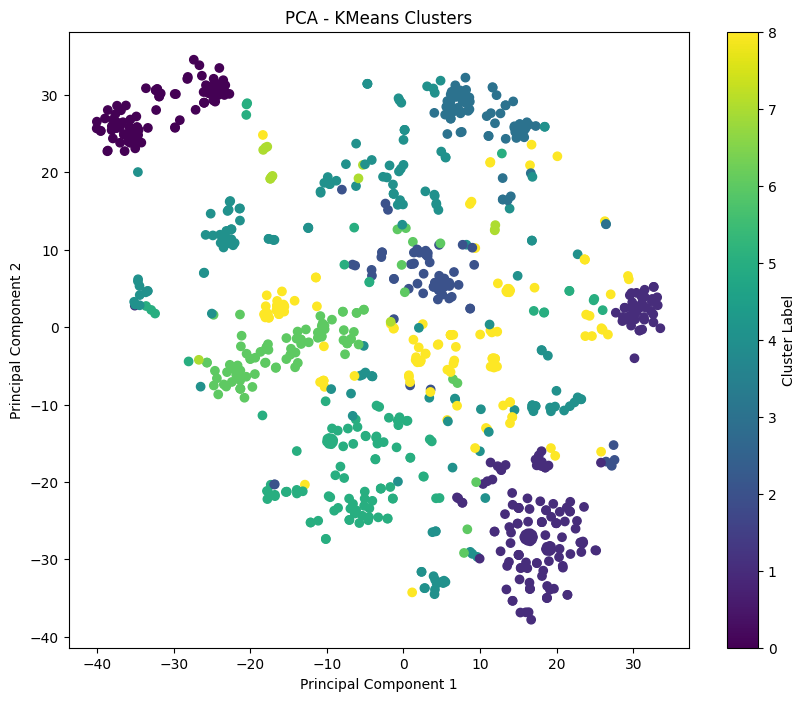

In [9]:
#####clustering
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
encoded_df = pd.read_csv('CDR3_encoded_dimension_doublechain_mouse.csv')
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer

cdr3_a_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3a_encoded']])
cdr3_b_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3b_encoded']])



# 合并CDR3a和CDR3b的编码后特征
cdr3_encoded_combined = np.hstack((cdr3_a_encoded, cdr3_b_encoded))
#n = [2,3,4,5,6,7,8,9]
# 应用KMeans聚类
# for i in n:
#     kmeans = KMeans(n_clusters = i,random_state=42)
#     clusters = kmeans.fit_predict(cdr3_encoded_combined)
#     cdr3_a_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3a_encoded']])
#     cdr3_b_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3b_encoded']])
#     cdr3_encoded_combined = np.hstack((cdr3_a_encoded, cdr3_b_encoded))
#     silhouette_avg = silhouette_score(cdr3_encoded_combined, clusters)
#     calinski_harabasz = calinski_harabasz_score(cdr3_encoded_combined, clusters)
#     davies_bouldin = davies_bouldin_score(cdr3_encoded_combined, clusters)
#     print(i)
#     print(f"Silhouette Score: {silhouette_avg}")
#     print(f"Calinski-Harabasz Score: {calinski_harabasz}")
#     print(f"Davies-Bouldin Score: {davies_bouldin}")
    
kmeans = KMeans(n_clusters=9, random_state=42) # 随机状态仅用于结果可重复性
clusters = kmeans.fit_predict(cdr3_encoded_combined)

pca = TSNE(n_components=2)
pca_result = pca.fit_transform(cdr3_encoded_combined)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, label = ['epitope_encoded'],cmap='viridis', marker='o')
plt.title('PCA - KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


# # 将聚类结果添加到原始DataFrame中
encoded_df['cluster'] = clusters

# # # 输出聚类结果
# # print(df.head())
# encoded_df.to_csv('cluster_large.csv',index = False)

In [46]:
cdr3_a_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3a_encoded']])
cdr3_b_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3b_encoded']])
cdr3_encoded_combined = np.hstack((cdr3_a_encoded, cdr3_b_encoded))
silhouette_avg = silhouette_score(cdr3_encoded_combined, clusters)
calinski_harabasz = calinski_harabasz_score(cdr3_encoded_combined, clusters)
davies_bouldin = davies_bouldin_score(cdr3_encoded_combined, clusters)
print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Davies-Bouldin Score: {davies_bouldin}")

Silhouette Score: 0.18706013000174185
Calinski-Harabasz Score: 19.22831333016905
Davies-Bouldin Score: 2.2447313399340016


In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 假设已经有了聚类结果
encoded_df = pd.read_csv('CDR3_encoded_complete.csv')
cdr3_a_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3a_encoded']])
cdr3_b_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3b_encoded']])
cdr3_encoded_combined = np.hstack((cdr3_a_encoded, cdr3_b_encoded))

# 应用KMeans聚类
kmeans = KMeans(n_clusters=30, random_state=42)
clusters = kmeans.fit_predict(cdr3_encoded_combined)

# 计算评估指标
silhouette_avg = silhouette_score(cdr3_encoded_combined, clusters)
calinski_harabasz = calinski_harabasz_score(cdr3_encoded_combined, clusters)
davies_bouldin = davies_bouldin_score(cdr3_encoded_combined, clusters)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Davies-Bouldin Score: {davies_bouldin}")


Silhouette Score: 0.029021484349840913
Calinski-Harabasz Score: 186.2191032011482
Davies-Bouldin Score: 4.020614614373148


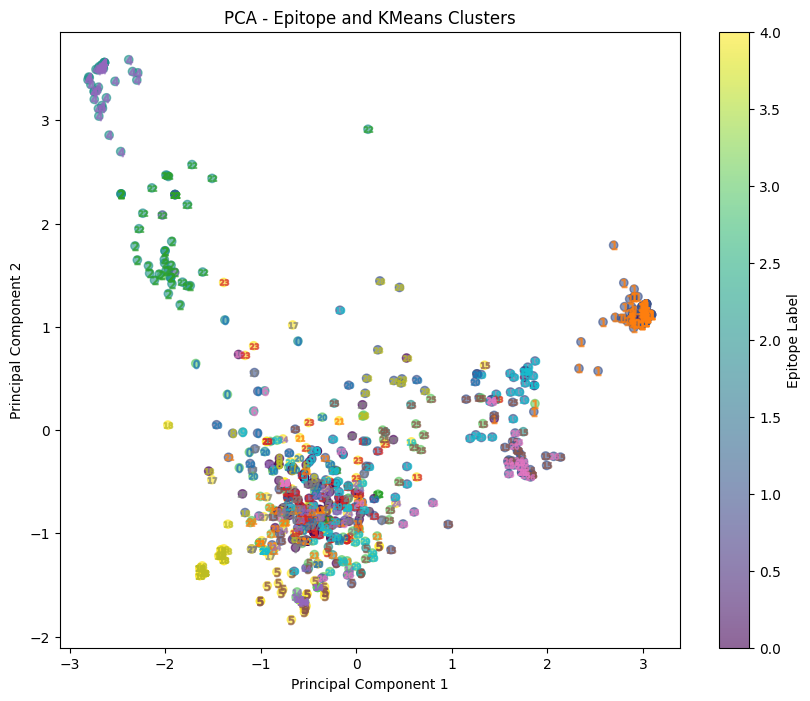

ValueError: Unrecognized marker style 'b'

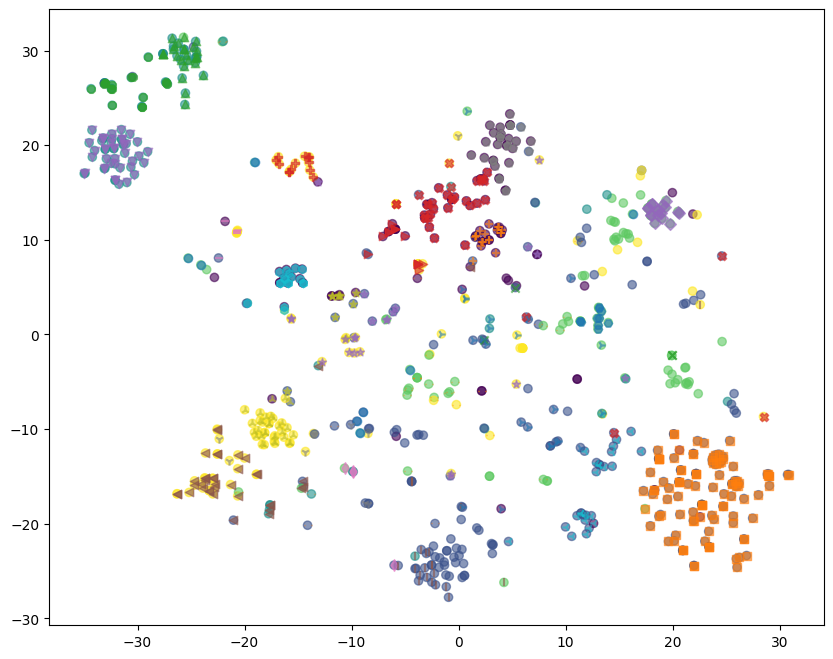

In [21]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
markers = ['o', 's', '^', '>', 'v', '<', 'd', 'p', '*', 'h', 'H', '+', 'x', 'X', 'D', '|', '_', '1', '2', '3', '4', '$...$', '8', 'P', '*', 'b', 'r', 'g', 'n', 'm', 'w']

# 加载数据
encoded_df = pd.read_csv('CDR3_encoded_dimension_doublechain_mouse.csv')
cdr3_a_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3a_encoded']])
cdr3_b_encoded = np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in encoded_df['CDR3b_encoded']])
cdr3_encoded_combined = np.hstack((cdr3_a_encoded, cdr3_b_encoded))

# 统计 epitope_encoded 字段的频率并找到最常见的五个
epitope_counts = encoded_df['antigen.epitope'].value_counts().nlargest(5)
common_epitopes = epitope_counts.index.tolist()

# 过滤数据集，只包含最常见的五种 epitope
filtered_df = encoded_df[encoded_df['antigen.epitope'].isin(common_epitopes)]
filtered_cdr3_encoded = np.hstack((np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in filtered_df['CDR3a_encoded']]),
                                   np.array([np.fromstring(seq, dtype=int, sep=' ') for seq in filtered_df['CDR3b_encoded']])))
epitope_labels = filtered_df['antigen.epitope'].values

# KMeans 聚类
kmeans = KMeans(n_clusters=30, random_state=42)
clusters = kmeans.fit_predict(filtered_cdr3_encoded)

# PCA 降维
pca = PCA(n_components=2)
pca_result = pca.fit_transform(filtered_cdr3_encoded)

# 可视化 PCA 结果
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=pd.factorize(epitope_labels)[0], cmap='viridis', marker='o', alpha=0.6)
# 使用不同的标记形状来代表不同的聚类
for i in range(30):
    plt.scatter(pca_result[clusters == i, 0], pca_result[clusters == i, 1], marker='${}$'.format(i), alpha=0.6)
plt.title('PCA - Epitope and KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Epitope Label')
plt.show()

# t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(filtered_cdr3_encoded)

# 可视化 t-SNE 结果
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=pd.factorize(epitope_labels)[0], cmap='viridis', alpha=0.6)
# 使用不同的标记形状来代表不同的聚类
for i in range(30):
    plt.scatter(tsne_result[clusters == i, 0], tsne_result[clusters == i, 1],marker=markers[i % len(markers)], alpha=0.6)
plt.title('t-SNE - Epitope and KMeans Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(scatter, label='Epitope Label')
plt.show()


In [14]:
df_neg = pd.read_csv('CDR3_encoded_complete_fake_small_mhc.csv')
df = pd.read_csv('cluster_large.csv')
df_unique = df.drop_duplicates(subset=['CDR3a_encoded', 'CDR3b_encoded'])
# 假设编码是以字符串形式存储，使用相同方式处理两个DataFrame中的编码字段
print(len(df_neg))
print(len(df))

147738
902


In [164]:
df_merged = pd.merge(df_neg, df_unique[['CDR3a_encoded', 'CDR3b_encoded', 'cluster']], 
                     on=['CDR3a_encoded', 'CDR3b_encoded'], 
                     how='left')
print(len(df_neg))
print(len(df_merged))
print(df_merged)
df_merged.to_csv('updated_CDR3_encoded_complete_fake.csv', index=False)

147738
147738
                                            CDR3a_encoded  \
0       0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
1       0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
2       0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
3       0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
4       0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
...                                                   ...   
147733  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
147734  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
147735  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
147736  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   
147737  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...   

                                            CDR3b_encoded  epitope_encoded  \
0       0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...                9   
1       0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 ...                9   
2       0 1 0 0 0 0

In [2]:
import pandas as pd
df = pd.read_csv('/Users/lifangyi/Desktop/data_clean_small_MusMusculus.csv', sep = '\t')

In [3]:
print(len(df))

902


In [18]:
encoded_df = pd.read_csv('CDR3_encoded_dimension_doublechain_mouse.csv')
print(len(encoded_df))

902


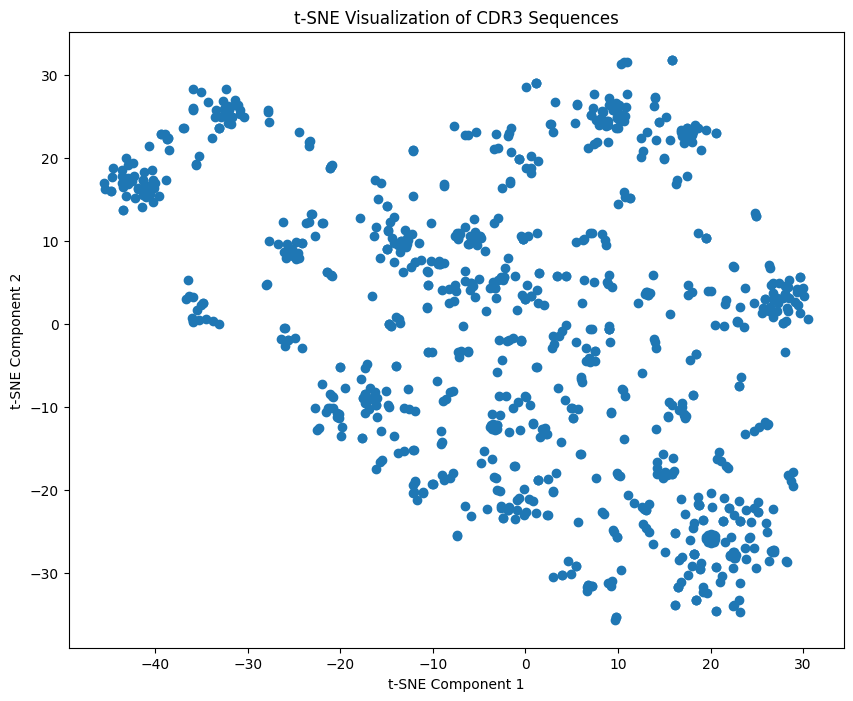

In [49]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(cdr3_encoded_combined)
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], label=encoded_df['cluster'])
plt.title('t-SNE Visualization of CDR3 Sequences')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


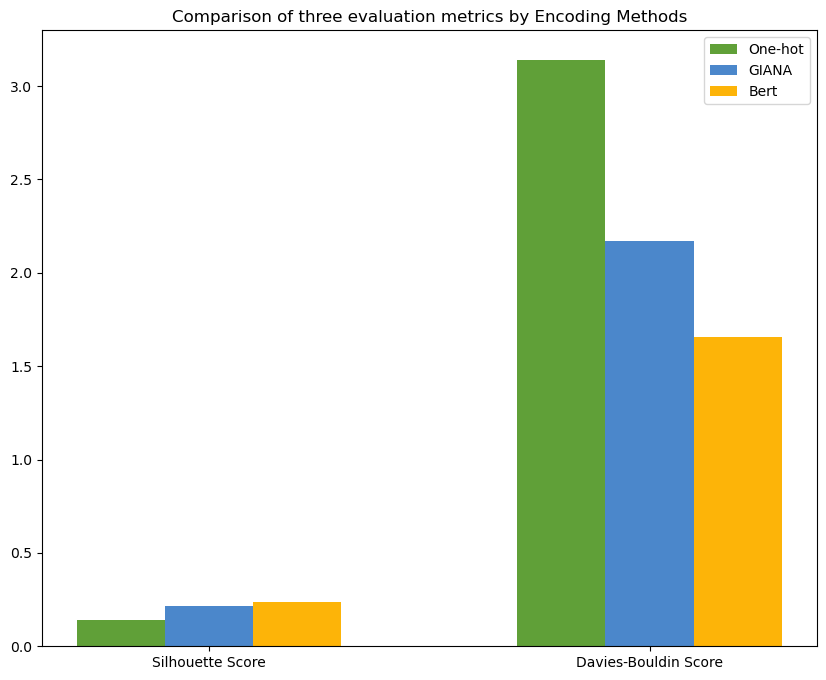

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# data = {
#       "metrics":["Accuracy","F1_score","AUROC"],
#       "One-Hot": [0.656, 0.3557, 0.77 ],
#       "Bert": [0.662, 0.364,0.79],
#       "GIANA": [0.64,  0.35, 0.77]
#  }
data = {
    "metrics":['Silhouette Score','Davies-Bouldin Score'],
    "One-Hot": [0.14074716117109132,  3.141835932681207],
    "GIANA": [0.21770908288814324,2.171050851268609],
   "Bert": [0.23744130868622095,  1.6570354136708991]
 }


df = pd.DataFrame(data)
plt.figure(figsize=(10, 8))

x_labels = df["metrics"].values
x = np.arange(len(x_labels))  # It's better to use np.arange for position indexing

# Define the colors using normalized RGB values
color_one_hot = (96/255, 160/255, 56/255)  # Normalized RGB for One-hot
color_giana = (75/255, 135/255, 203/255)  # Normalized RGB for GIANA
color_bert = (253/255, 180/255, 8/255)  # Normalized RGB for Bert

# Plotting
plt.bar(x, df["One-Hot"], width=0.2, label='One-hot', color=color_one_hot)
plt.bar(x + 0.2, df["GIANA"], width=0.2, label='GIANA', color=color_giana)
plt.bar(x + 0.4, df["Bert"], width=0.2, label='Bert', color=color_bert)

# Setting x-ticks
plt.xticks(x + 0.2, x_labels)  # Center the labels

plt.legend()

plt.title('Comparison of three evaluation metrics by Encoding Methods')

plt.show()

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# 数据集
data = {
    "metrics": ["Silhouette Score", "Calinski-Harabasz Score", "Davies-Bouldin Score"],
    "One-Hot": [0.14074716117109132, 42.58403548313001, 3.141835932681207],
    "GIANA": [0.048410773277282715, 6.507306509900774, 1.1500318899656738],
    "Bert": [0.19744130868622095, 110.16905086071719, 1.6570354136708991]
}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10, 8))
x = range(len(df["metrics"]))


ax1.bar(x, df["One-Hot"], width=0.2, label='One-Hot')
ax1.bar([i+0.2 for i in x], df["GIANA"], width=0.2, label='GIANA')
ax1.bar([i+0.4 for i in x], df["Bert"], width=0.2, label='Bert')
ax1.set_ylim(0, 4)
ax1.set_xticks([i+0.1 for i in x])
ax1.set_xticklabels(df["metrics"])
ax1.set_ylabel('Silhouette Score / Davies-Bouldin Score')

ax2 = ax1.twinx() ax2.bar(x, df["One-Hot"], width=0.2, label='One-Hot')
ax2.bar([i+0.2 for i in x], df["GIANA"], width=0.2, label='GIANA')
ax2.bar([i+0.4 for i in x], df["Bert"], width=0.2, label='Bert', color='green')
ax2.set_ylabel('Calinski-Harabasz Score')
ax2.set_ylim(0, 200)

# 设置图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 设置标题
plt.title('Comparison of Clustering Metrics by Encoding Methods')

# 显示图形
plt.show()


SyntaxError: invalid syntax (2220267274.py, line 26)